# Практическое задание №5 по теме "Рекуррентные нейронные сети".

1. Попробуйте изменить параметры нейронной сети работающей с датасетом imdb либо нейронной сети работающей airline-passengers(она прилагается вместе с датасетом к уроку в виде отдельного скрипта) так, чтобы улучшить ее точность. Приложите анализ.
2. Попробуйте изменить параметры нейронной сети генерирующий текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший получившейся у вас текст и опишите, что вы предприняли, чтобы его получить. Можно использовать текст другого прозведения.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Bidirectional
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

## Задание 1

Загрузим данные

In [3]:
np.random.seed(7)
tf.random.set_seed(7)

dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [4]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

Обучим нейронную сеть

In [5]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()

Предсказание

In [6]:
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

44/44 [==============================] - 0s 2ms/step


In [7]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [8]:
trainScoreBase = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScoreBase = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

In [9]:
trainPredictPlotBase = np.empty_like(dataset)
trainPredictPlotBase[:, :] = np.nan
trainPredictPlotBase[look_back:len(trainPredict)+look_back, :] = trainPredict

In [10]:
testPredictPlotBase = np.empty_like(dataset)
testPredictPlotBase[:, :] = np.nan
testPredictPlotBase[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

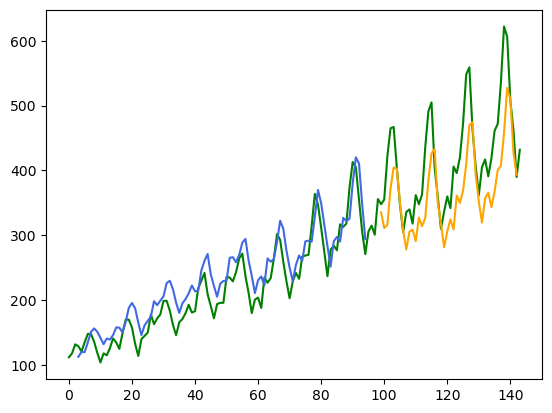

Train Score: 30.85 RMSE
Test Score: 69.13 RMSE


In [11]:
plt.plot(scaler.inverse_transform(dataset), c='green')
plt.plot(trainPredictPlotBase, c='royalblue')
plt.plot(testPredictPlotBase, c='orange')
plt.show()

print('Train Score: %.2f RMSE' % (trainScoreBase))
print('Test Score: %.2f RMSE' % (testScoreBase))

**Попробуем улучшить результаты**

In [12]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [13]:
batch_size = 1

model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()

In [14]:
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

44/44 [==============================] - 0s 2ms/step


In [15]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [16]:
trainScoreNew = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScoreNew = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

In [17]:
trainPredictPlotNew = np.empty_like(dataset)
trainPredictPlotNew[:, :] = np.nan
trainPredictPlotNew[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlotNew = np.empty_like(dataset)
testPredictPlotNew[:, :] = np.nan
testPredictPlotNew[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

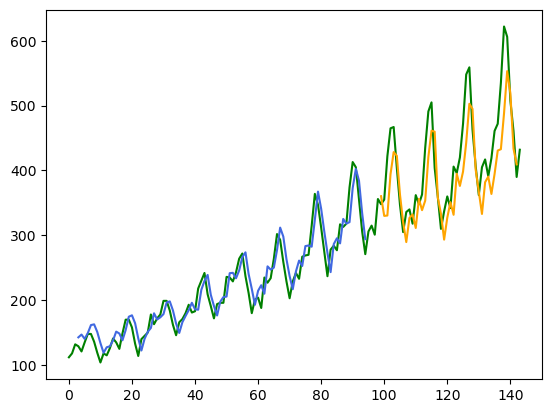

Train Score: 21.82 RMSE
Test Score: 51.91 RMSE


In [18]:
plt.plot(scaler.inverse_transform(dataset), c='green')
plt.plot(trainPredictPlotNew, c='royalblue')
plt.plot(testPredictPlotNew, c='orange')
plt.show()

print('Train Score: %.2f RMSE' % (trainScoreNew))
print('Test Score: %.2f RMSE' % (testScoreNew))

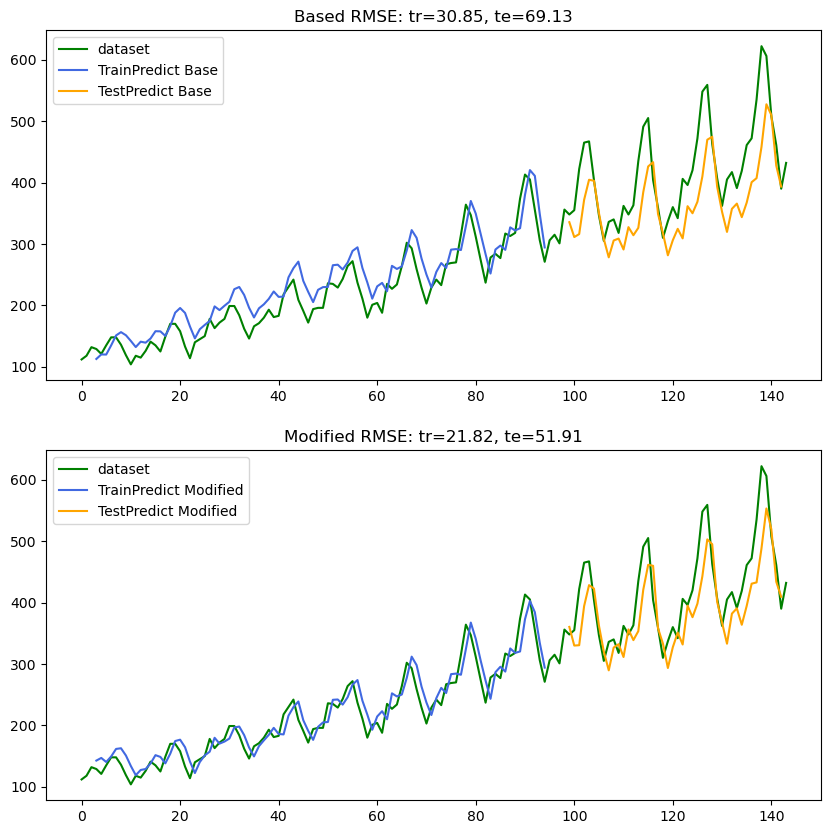

In [19]:
plt.figure(figsize=(10,10))
plt.subplot(2, 1, 1)
plt.title(f"Based RMSE: tr={trainScoreBase:.2f}, te={testScoreBase:.2f}")
plt.plot(scaler.inverse_transform(dataset),'g', label = 'dataset')
plt.plot(trainPredictPlotBase,'royalblue', label = 'TrainPredict Base')
plt.plot(testPredictPlotBase,'orange', label = 'TestPredict Base')
plt.legend()
plt.subplot(2, 1, 2)
plt.title(f"Modified RMSE: tr={trainScoreNew:.2f}, te={testScoreNew:.2f}")
plt.plot(scaler.inverse_transform(dataset),'g', label = 'dataset')
plt.plot(trainPredictPlotNew,'royalblue', label = 'TrainPredict Modified')
plt.plot(testPredictPlotNew,'orange', label = 'TestPredict Modified')
plt.legend()
plt.show()

Как видно из результатов и графиков, настройка скорости обучения оптимайзера Adam помогла улучшить результат. 

Остальные многочисленные эксперименты с размером батча, с числом слоев, с числом нейронов, с количеством эпох и добавление Dropout не смогли дать какого-то лучшего результата метрик, а в большинстве своем только их ухудшали.

## Задание 2

Загрузка данных

In [61]:
data = open('sonnets.txt').read()
corpus = data.lower().split("\n")
corpus[:10]

['\tsonnets',
 '',
 '',
 '',
 'to the only begetter of',
 'these insuing sonnets',
 'mr. w. h. all happiness',
 'and that eternity',
 'promised by',
 'our ever-living poet wisheth']

In [62]:
# Создаем объект для токенизации
total_words = 1000
tokenizer = Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(corpus)

In [63]:
print(corpus[0])
print(tokenizer.texts_to_sequences([corpus[0]]))
print(tokenizer.word_index['from'], tokenizer.word_index['fairest'])

	sonnets
[[878]]
34 418


In [64]:
# создадим последовательность токенов
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        sequence = token_list[:i+1]
        input_sequences.append(sequence)
input_sequences[:10]

[[3, 2],
 [3, 2, 313],
 [3, 2, 313, 4],
 [118, 878],
 [1, 8],
 [1, 8, 517],
 [126, 186],
 [126, 186, 278],
 [126, 186, 278, 635],
 [2, 98]]

In [65]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
print(max_sequence_len)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[:10]

11


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   3,   2, 313],
       [  0,   0,   0,   0,   0,   0,   0,   3,   2, 313,   4],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 118, 878],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   8],
       [  0,   0,   0,   0,   0,   0,   0,   0,   1,   8, 517],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 126, 186],
       [  0,   0,   0,   0,   0,   0,   0,   0, 126, 186, 278],
       [  0,   0,   0,   0,   0,   0,   0, 126, 186, 278, 635],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   2,  98]])

In [66]:
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]

label = to_categorical(label, num_classes=total_words)
label.shape

(12887, 1000)

In [67]:
predictors[0], np.argmax(label[0])

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 3]), 2)

Обучим нейронную сеть

In [78]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

model = Sequential()
model.add(Embedding(input_dim=total_words,
                    output_dim=512,
                    input_length=max_sequence_len-1))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
# model.add(Bidirectional(LSTM(512, return_sequences=True)))
# model.add(Bidirectional(LSTM(512, return_sequences=True)))
model.add(LSTM(1024))
model.add(Dropout(0.25))
model.add(Dense(total_words * 2 , activation='relu'))
# model.add(Dense(total_words * 2 , activation='relu'))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 10, 512)           512000    
                                                                 
 bidirectional_10 (Bidirecti  (None, 10, 512)          1574912   
 onal)                                                           
                                                                 
 lstm_18 (LSTM)              (None, 1024)              6295552   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 2000)              2050000   
                                                                 
 dense_14 (Dense)            (None, 1000)              2001000   
                                                      

In [79]:
with tf.device("GPU:0"):
    history = model.fit(predictors, label,
                    epochs=100,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/100
323/323 [==============================] - 10s 21ms/step - loss: 5.9886 - accuracy: 0.0320 - val_loss: 5.9853 - val_accuracy: 0.0275
Epoch 2/100
323/323 [==============================] - 6s 19ms/step - loss: 5.6973 - accuracy: 0.0453 - val_loss: 5.8850 - val_accuracy: 0.0400
Epoch 3/100
323/323 [==============================] - 6s 19ms/step - loss: 5.5200 - accuracy: 0.0535 - val_loss: 5.8553 - val_accuracy: 0.0477
Epoch 4/100
323/323 [==============================] - 6s 19ms/step - loss: 5.2649 - accuracy: 0.0748 - val_loss: 5.8935 - val_accuracy: 0.0562
Epoch 5/100
323/323 [==============================] - 6s 18ms/step - loss: 4.9984 - accuracy: 0.0895 - val_loss: 6.0715 - val_accuracy: 0.0555
Epoch 6/100
323/323 [==============================] - 6s 18ms/step - loss: 4.7036 - accuracy: 0.1050 - val_loss: 6.3079 - val_accuracy: 0.0601
Epoch 7/100
323/323 [==============================] - 6s 19ms/step - loss: 4.3540 - accuracy: 0.1262 - val_loss: 6.6026 - val_accuracy

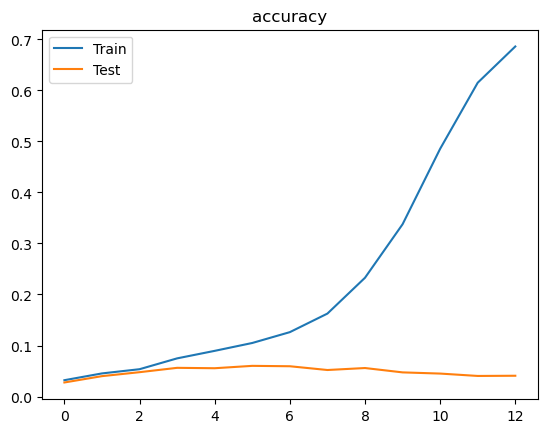

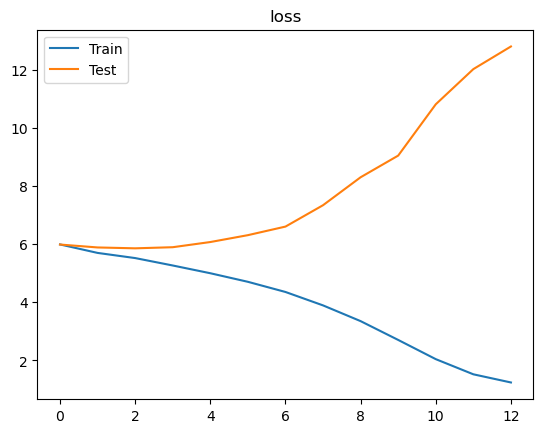

In [80]:
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Train')
plt.plot(epochs, acc_v, label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, label='Train')
plt.plot(epochs, loss_v, label='Test')
plt.title('loss')
plt.legend()

plt.show()

**Генерируем текст**

In [81]:
seed_text = "Deep in the darkest part of your heart"

In [82]:
next_words = 10
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    print(token_list)
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_proba = model.predict(token_list, verbose=0)
    predicted_classes = np.argmax(predicted_proba, axis=1)

    output_word = tokenizer.index_word[predicted_classes[0]]
    seed_text += " " + output_word
    
print(seed_text)

[283, 7, 2, 125, 4, 31, 56]
[283, 7, 2, 125, 4, 31, 56, 32]
[283, 7, 2, 125, 4, 31, 56, 32, 562]
[283, 7, 2, 125, 4, 31, 56, 32, 562, 125]
[283, 7, 2, 125, 4, 31, 56, 32, 562, 125, 344]
[283, 7, 2, 125, 4, 31, 56, 32, 562, 125, 344, 18]
[283, 7, 2, 125, 4, 31, 56, 32, 562, 125, 344, 18, 28]
[283, 7, 2, 125, 4, 31, 56, 32, 562, 125, 344, 18, 28, 13]
[283, 7, 2, 125, 4, 31, 56, 32, 562, 125, 344, 18, 28, 13, 20]
[283, 7, 2, 125, 4, 31, 56, 32, 562, 125, 344, 18, 28, 13, 20, 239]
Deep in the darkest part of your heart doth rehearse part set me it is so great one


---